## Sentiment Analysis on Stanford's Movie Review Corpus

In [36]:
RANDOM_SEED = 42

In [31]:
import pandas as pd
import os

def load_data_from_directory(directory, sentiment):
    reviews = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            reviews.append(file.read())
    return pd.DataFrame({
        'review': reviews,
        'sentiment': sentiment
    })

def load_datasets(base_path):
    # Load training data
    pos_train_df = load_data_from_directory(os.path.join(base_path, "train/pos"), 1)
    neg_train_df = load_data_from_directory(os.path.join(base_path, "train/neg"), 0)
    
    # Load testing data
    pos_test_df = load_data_from_directory(os.path.join(base_path, "test/pos"), 1)
    neg_test_df = load_data_from_directory(os.path.join(base_path, "test/neg"), 0)
    
    # Combine train data and shuffle
    train_df = pd.concat([pos_train_df, neg_train_df], ignore_index=True)
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Combine test data and shuffle
    test_df = pd.concat([pos_test_df, neg_test_df], ignore_index=True)
    test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return train_df, test_df


# Load the train and test datasets
train_ds, test_ds = load_datasets("aclImdb")
print("Train Data:")
display(train_ds.head())

print("\nTest Data:")
display(test_ds.head())


Train Data:


,review,sentiment
0,Great little thriller. I was expecting some ty...,1
1,"Nothing could have saved this movie, not even ...",0
2,This was a good movie. It wasn't your typical ...,1
3,From the pen of Richard Condon (The Manchurian...,0
4,I suppose that today this film has relevance b...,0



Test Data:


,review,sentiment
0,Yul Brynner was a symbol of villein in the tin...,1
1,This show has been performed live around the c...,0
2,To sum this story up in a few sentences: A tee...,1
3,This is absolutely beyond question the worst m...,0
4,A box with a button provides a couple with the...,0


In [ ]:
!python -m spacy download en_core_web_sm

In [32]:
import re
import spacy
import contractions


nlp = spacy.load("en_core_web_sm")
stopwords = set(nlp.Defaults.stop_words)
tokenizer = nlp.tokenizer

# Pre-Process Text
def preprocess_text(text):
    # Removing special characters and numbers
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # Removing all HTML Tags
    text = re.sub(r'<.*?>', '', text)
    # Removing links
    text = re.sub(r'http\S+', '', text)
    # Remove Text Contractions
    text = contractions.fix(text)
    # Removing stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # remove extra spaces
    text = re.sub(' +', ' ', text)
    return text



# Preprocess the reviews
train_ds['review'] = train_ds['review'].apply(preprocess_text)
test_ds['review'] = test_ds['review'].apply(preprocess_text)


In [34]:
train_ds.head()


,review,sentiment
0,Great little thriller I expecting type silly h...,1
1,Nothing saved movie Superman br br Ten years a...,0
2,This good movie It wasn t typical war flick bi...,1
3,From pen Richard Condon The Manchurian Candida...,0
4,I suppose today film relevance early Sofia Lor...,0


In [38]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(
    train_ds['review'], 
    train_ds['sentiment'], 
    test_size=0.10, 
    random_state=RANDOM_SEED,
)

X_test, y_test = test_ds['review'], test_ds['sentiment']

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Using TF-IDF with ngrams (uni-grams and bi-grams)
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score



def train_and_score(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """
    Train the provided model and evaluate its performance on validation data.

    Parameters:
    - model: The ML model to be trained.
    - X_train, y_train: Training data.
    - X_val, y_val: Validation data.
    - model_name: Name of the model (for display purposes).

    Returns:
    - Validation accuracy of the model.
    """
    
    # Train the model on training data
    model.fit(X_train, y_train)

    # Predict on validation data
    val_predictions = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_predictions)
    
    # Predict on test data
    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    # Print the model's accuracy
    print(f"\n{model_name}: ")
    print(f"> Val Acc: {val_accuracy * 100:.2f}%")
    print(f"> Test Acc: {test_accuracy * 100:.2f}%")
    
    return val_accuracy, test_accuracy



# Train and evaluate different models

# SVM
svm_val_accuracy, svm_test_accuracy = train_and_score(
    LinearSVC(random_state=RANDOM_SEED), X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Linear SVM")

# Naive Bayes
nb_val_accuracy, nb_test_accuracy = train_and_score(
    MultinomialNB(), X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Naive Bayes")

# Logistic Regression
lr_val_accuracy, lr_test_accuracy = train_and_score(
    LogisticRegression(random_state=RANDOM_SEED), X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Logistic Regression")

# Random Forest
rf_val_accuracy, rf_test_accuracy = train_and_score(
    RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100), X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Random Forest")

# Gradient Boosting
gb_val_accuracy, gb_test_accuracy = train_and_score(
    GradientBoostingClassifier(random_state=RANDOM_SEED), X_train_vec, y_train, X_val_vec, y_val, X_test_vec, y_test, "Gradient Boosting")



/Users/parsamz/Canvas/NLP-220/HW1/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Linear SVM: 
> Val Acc: 91.08%
> Test Acc: 88.82%

Naive Bayes: 
> Val Acc: 88.76%
> Test Acc: 85.66%

Logistic Regression: 
> Val Acc: 89.84%
> Test Acc: 87.37%

Random Forest: 
> Val Acc: 84.92%
> Test Acc: 84.49%

Gradient Boosting: 
> Val Acc: 81.40%
> Test Acc: 80.75%


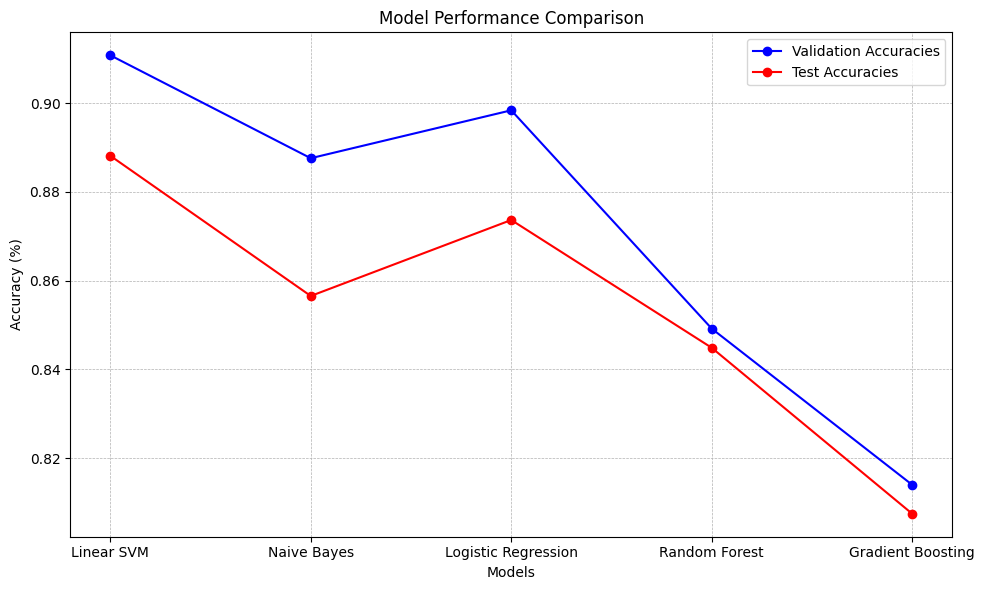

In [47]:
import matplotlib.pyplot as plt

# Define models and accuracies
models = ['Linear SVM', 'Naive Bayes', 'Logistic Regression', 'Random Forest', 'Gradient Boosting']
val_accuracies = [svm_val_accuracy, nb_val_accuracy, lr_val_accuracy, rf_val_accuracy, gb_val_accuracy]
test_accuracies = [svm_test_accuracy, nb_test_accuracy, lr_test_accuracy, rf_test_accuracy, gb_test_accuracy]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(models, val_accuracies, marker='o', label='Validation Accuracies', color='b')
plt.plot(models, test_accuracies, marker='o', label='Test Accuracies', color='r')

# Set labels, title, legend, etc.
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()
